## overview
- training a model using masking to predict missing values in order to evaluate patient's overall performance
- visualization for how prediction does overall compared to imputation as a baseline test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
import random

Initialize run

Data

In [2]:
df = pd.read_csv("data/filtered_model_data.csv")

In [3]:
df["start_time"] = df["start_time"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time"])

Create training data

In [4]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [5]:
def create_training_data(data : pd.DataFrame):
    score = np.empty((1,14))
    score.fill(np.nan)
    scores = np.zeros((len(data), 14))
    i = 0
    
    data = data.sort_values(by=["start_time"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [6]:
# def create_training_data(data : pd.DataFrame):
#     scores = np.zeros((data["start_time_min"].map(lambda t: t.date()).nunique(), 14))
#     # scores[:, 0] = data["patient_id"].iloc[0] # set first column to be patient id
#     i = 0

#     data = data.sort_values(by=["start_time_min"])
#     prevday = None
#     curday_score = np.zeros((1,14))

#     for idx, row in data.iterrows():
#         curday = row["start_time_min"].date()
#         domains, domain_scores = process_row(row)

#         # if curday is a different day than the previous day, set scores[i] to the curday scores, increment the counter
#         if curday != prevday and prevday != None:
#             scores[i] = curday_score
#             i += 1
#         # loop through the domains, update corresponding score in curdayscore
#         for j in range(len(domains)):
#             # print(j)
#             curday_score[0, int(domains[j] - 1)] = domain_scores[j]
#         # we finished the session, set prevday to curday
#         prevday = curday
    
#     scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
#     scores_df.reset_index(drop=True, inplace=True)
#     return scores_df

In [7]:
data = df.groupby("patient_id").apply(create_training_data, include_groups=False).reset_index(drop=True)

In [8]:
model_data = data[["domain %d score" % i for i in range(1, 15)]]

In [9]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [10]:
# model_data = filter_nonzero_rows(model_data, 0) # second parameter is max number of zeros
model_data.dropna(inplace=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_30282/2304702615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.dropna(inplace=True)


In [11]:
model_data.shape

(1654070, 14)

In [12]:
train_data, test_data = train_test_split(model_data, test_size=0.25)

In [13]:
train_data.shape, test_data.shape

((1240552, 14), (413518, 14))

In [14]:
train_data = train_data.to_numpy()

In [15]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [16]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    data = copy.deepcopy(data)
    return data * mask, n_zeros, mask

In [17]:
# take a numpy array for data, an int for dupe_n, return an array of shape (dupe_n * n_row, col) where
# every ith matrix of shape (n_row, col), the data has i domains masked
def generate_differently_masked_data(original_matrix, dupe_n=14):
    n_row, n_col = original_matrix.shape
    new_matrix = np.zeros((n_row * dupe_n, n_col), dtype=float)
    new_ground_truth = np.zeros((n_row * dupe_n, n_col), dtype=float)
    for i in range(dupe_n):
        masked_matrix, _, _ = generate_mask(original_matrix, N = i)
        new_matrix[i * n_row:(i + 1) * n_row, :] = masked_matrix
        new_ground_truth[i * n_row:(i + 1) * n_row, :] = original_matrix
    return new_matrix, new_ground_truth

In [18]:
train_data, ground_truth = generate_differently_masked_data(train_data, dupe_n=14)

In [19]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [20]:
train_data = create_missing_indicator(train_data)
ground_truth = create_missing_indicator(ground_truth)

In [21]:
train_data.shape, ground_truth.shape, test_data.shape

((17367728, 28), (17367728, 28), (413518, 14))

Model

In [22]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 100
        hidden2 = 25
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, hidden2),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden2, hidden1),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2)
        )

    def forward(self, x):
        return torch.clamp(self.model(x), min=0, max=1)

masking

In [23]:
def missing(arr):
    assert(len(arr) == 2)
    # if two values are the same (the only three possible values pairs are (0, 0), (1, 1), and (0.5, 0.5) and only 0.5 isn't a missing indicator)
    return arr[0] == arr[1] and (arr[0] == 0 or arr[0] == 1)

Training

In [24]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w * 2)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            # handle missing value
            # missing_exists = False
            # missing_domains = []
            # for domain in range(w):
            #     if missing(session[domain*2:domain*2+2]):
            #         missing_exists = True
            #         missing_domains.append(domain)
            

            target = copy.deepcopy(y_train[i].reshape(-1, w * 2))
            # if missing_exists:
            #     recon = reconstructed.detach().numpy()
            #     for d in missing_domains:
            #         target[0, d*2:d*2+2] = recon[0, d*2:d*2+2]
            target = torch.from_numpy(target).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w * 2)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.from_numpy(y_val[k].reshape(-1, w * 2)).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [25]:
num_runs = 1

In [26]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = AE()
    epochs = 3
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(train_data, ground_truth, test_size=0.50) # further splitting training set into train and validation
    model.eval()
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

In [27]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='%s Mean' %setting, color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='%s Standard Deviation' % setting)
    
    plt.title('Mean and Standard Deviation Plot')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

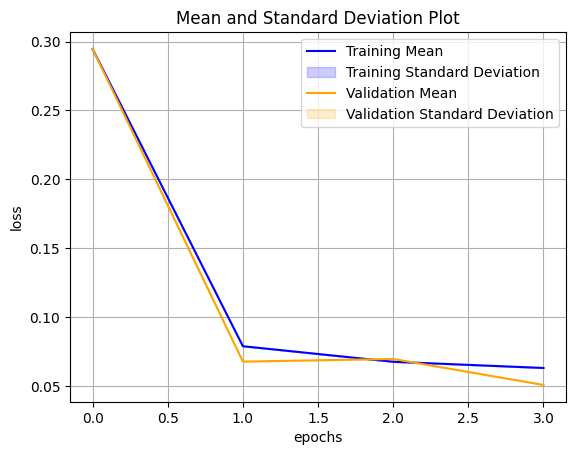

In [28]:
# Plotting
with torch.no_grad():
    plot_mean_and_std(losses_2d, "blue", "Training")
    plot_mean_and_std(val_losses_2d, "orange", "Validation")

In [29]:
np.mean(x_train, axis=0)

array([0.52900962, 0.47117981, 0.52526456, 0.47459265, 0.6827966 ,
       0.31762372, 0.50510028, 0.49483788, 0.4008788 , 0.59953554,
       0.51252321, 0.48732743, 0.51274616, 0.48722585, 0.59104362,
       0.40909226, 0.45276613, 0.54773457, 0.53391204, 0.4665115 ,
       0.6710614 , 0.32895726, 0.46554899, 0.53453622, 0.5990847 ,
       0.40112016, 0.5669301 , 0.43338577])

Error Plots

In [30]:
## data average
def impute_with_column_mean(data : pd.DataFrame):
    """
    Imputes missing values (represented as 0) in a DataFrame with the mean of the non-zero values in the same column.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed using column means.
    """
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)
    
    # Calculate the mean of each column, ignoring NaNs
    column_means = imputed_data.mean()
    # replace the nans with 0 since that means there's no data at all for that column
    column_means = column_means.replace(np.nan, 0)

    
    # Replace NaN values in each column with the mean of that column
    imputed_data.fillna(column_means, inplace=True)

    return imputed_data

In [31]:
## known domain average
def impute_with_row_average(data : pd.DataFrame):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    imputed_data = data.copy()
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)

    # Iterate over each row
    for index, row in imputed_data.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row.mean()
        if np.isnan(mean_value):
            mean_value = 0

        # Replace NaN values in the row with the calculated mean
        imputed_data.loc[index] = row.fillna(mean_value)

    return imputed_data

In [32]:
# mode = other => impute by average of other domains, mode = data => impute by average of the data set
def imputation(data, mode=""):
    if mode == "other":
        return impute_with_row_average(data)
    elif mode == "data":
        return impute_with_column_mean(data)

In [33]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data_t).clone().detach().numpy()

In [34]:
test_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
2317999,0.628,1.00,0.933,0.500,0.480,0.632,0.470,0.667,0.690,0.800,1.00,0.393,0.564,1.000
4402179,0.926,1.00,1.000,1.000,1.000,0.320,0.633,0.894,0.707,1.000,1.00,1.000,0.838,0.680
4651174,0.337,1.00,0.815,0.963,0.845,0.733,1.000,1.000,1.000,1.000,1.00,1.000,0.838,0.326
2911601,0.615,0.39,0.933,0.414,0.260,0.431,0.310,1.000,0.310,0.621,1.00,0.350,0.430,0.874
3468637,0.071,0.09,0.733,0.186,0.030,0.053,0.460,0.317,0.000,0.071,0.20,0.172,0.273,0.893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607401,0.629,0.55,1.000,0.329,0.150,1.000,0.610,1.000,0.280,0.800,1.00,0.715,0.163,0.740
1215275,0.211,0.02,0.370,0.363,0.123,0.695,0.711,0.259,0.106,0.408,0.72,0.254,0.270,0.260
4989217,0.415,0.24,1.000,0.214,0.200,0.653,0.450,1.000,0.230,0.507,1.00,0.314,0.606,0.347
1884438,0.843,0.28,0.707,0.300,0.150,0.400,0.840,1.000,0.230,0.328,1.00,0.214,0.400,0.800


In [35]:
column_names = ["domain %d score" % i for i in range(1, 15)]
accuracy_list_prediction_sq = []
accuracy_list_knownimputation_sq = []
accuracy_list_dataimputation_sq = []
accuracy_list_prediction_abs = []
accuracy_list_knownimputation_abs = []
accuracy_list_dataimputation_abs = []

In [36]:
def create_new_array_2d(ground_truth, prediction, masked):
    # Ensure all arrays have the same shape
    if ground_truth.shape != prediction.shape or prediction.shape != masked.shape:
        raise ValueError("All arrays must have the same shape")

    # Initialize the new array with the same shape
    new_array = np.empty_like(ground_truth)

    # Iterate through each row
    for i in range(ground_truth.shape[0]):
        # Iterate through each pair of values in the row
        for j in range(0, ground_truth.shape[1], 2):
            pair_masked = masked[i, j:j+2]
            # print(pair_masked)
            # Check if the pair in the masked array is missing
            if pair_masked[0] == pair_masked[1] and (pair_masked[0] == 1 or pair_masked[0] == 0):
                # print(i, j, pair_masked)
                # Use the corresponding pair from the prediction array
                new_array[i, j:j+2] = prediction[i, j:j+2]
            else:
                # Use the corresponding pair from the ground truth array
                new_array[i, j:j+2] = ground_truth[i, j:j+2]

    return new_array

In [37]:
def get_accuracy(y_pred, y_true, mask, fn : str):
    mask = mask ^ 1
    n_missing = np.sum(mask)
    y_pred *= mask
    y_true *= mask
    diff = y_pred - y_true
    if n_missing == 0: n_missing = 1
    if fn == "mse":
        # print(np.sum(np.power(diff, 2)))
        return np.sum(np.power(diff, 2)) / n_missing
    elif fn == "mae":
        # print(np.sum(np.abs(diff)))
        return np.sum(np.abs(diff)) / n_missing

In [38]:
from scipy.stats import sem

for masked_number in range(14):
    # masked_ratio = masked_number / 14
    ## create masked testing data so we can see how the model predicts and how imputation compares
    masked_test_data, n_missing, mask = generate_mask(test_data[column_names].copy().to_numpy(), N=masked_number)
    assert n_missing == masked_number * test_data.shape[0], "n missing weird"
    assert n_missing == np.size(mask) - np.sum(mask), "n missing weird"

    # impute 
    imputataion_data_data = imputation(pd.DataFrame(masked_test_data, columns=column_names), mode="data").to_numpy()
    imputataion_data_known = imputation(pd.DataFrame(masked_test_data, columns=column_names), mode="other").to_numpy()
    

    # predict
    masked_test_data = create_missing_indicator(masked_test_data)
    predictions = predict(masked_test_data, model)[:, ::2]

    ## get accuracy (abs)
    original = test_data[column_names].copy().to_numpy()
    assert original.shape == mask.shape and original.shape == predictions.shape and original.shape == imputataion_data_data.shape \
           and original.shape == imputataion_data_known.shape, "shape weird"
    
    accuracy_list_prediction_abs.append(get_accuracy(predictions, original, mask, "mae"))

    accuracy_list_dataimputation_abs.append(get_accuracy(imputataion_data_data, original, mask, "mae"))

    accuracy_list_knownimputation_abs.append(get_accuracy(imputataion_data_known, original, mask, "mae"))

    ## get accuracy (sq)
    accuracy_list_prediction_sq.append(get_accuracy(predictions, original, mask, "mse"))

    accuracy_list_dataimputation_sq.append(get_accuracy(imputataion_data_data, original, mask, "mse"))

    accuracy_list_knownimputation_sq.append(get_accuracy(imputataion_data_known, original, mask, "mse"))


Visualization

In [39]:
get_accuracy(predictions, original, mask, "mae"), get_accuracy(predictions, original, mask, "mse")

(0.22005613985488576, 0.07614740675834769)

In [40]:
accuracy_list_prediction_abs

[0.0,
 0.15962832700011625,
 0.161525687508268,
 0.1643173828728555,
 0.16703555231540748,
 0.16981716823293694,
 0.17287690083004123,
 0.17620359441012454,
 0.1801130026727717,
 0.1843525055145504,
 0.18955006707614575,
 0.19623839636879237,
 0.2055189461209804,
 0.22005613985488576]

In [41]:
accuracy_list_prediction_sq

[0.0,
 0.04681811199690387,
 0.04764422298174079,
 0.048946039287491944,
 0.05018043641658459,
 0.05143629725725555,
 0.05285707466979735,
 0.054358350856435554,
 0.05628247751179604,
 0.05825850201430568,
 0.06072364450124204,
 0.06398730982108312,
 0.06858655734821067,
 0.07614740675834769]

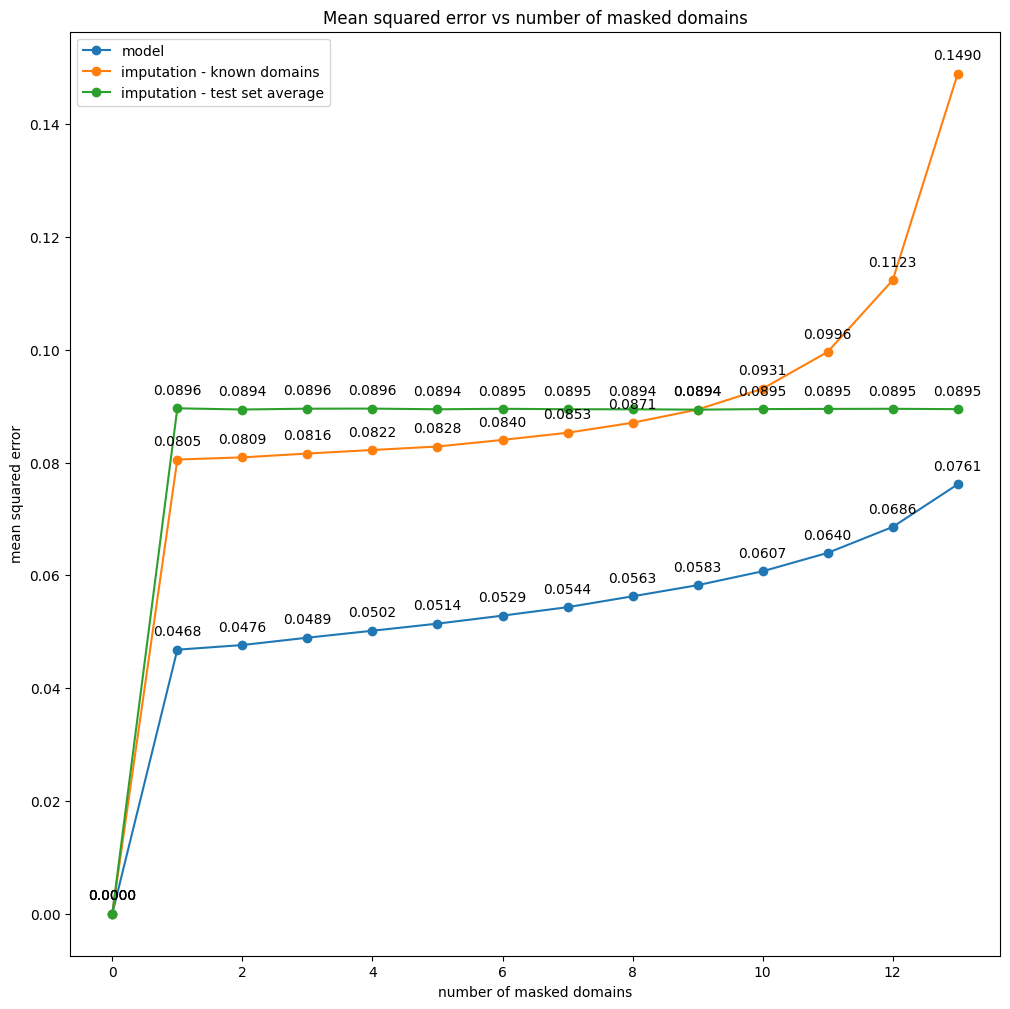

In [42]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_sq, yerr=error_prediction_sq, label="prediction", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_sq, yerr=error_imputation_sq, label="imputation")

x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_sq, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_sq, label="imputation - known domains", marker="o")
plt.plot(x_values, accuracy_list_dataimputation_sq, label="imputation - test set average", marker="o")

for x, y1, y2, y3 in zip(x_values, accuracy_list_prediction_sq, accuracy_list_knownimputation_sq, accuracy_list_dataimputation_sq):
    offset = 10

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y3)
    plt.annotate(label, # this is the text
                (x,y3), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center



plt.xlabel("number of masked domains")
plt.ylabel("mean squared error")
plt.title("Mean squared error vs number of masked domains")
plt.legend()

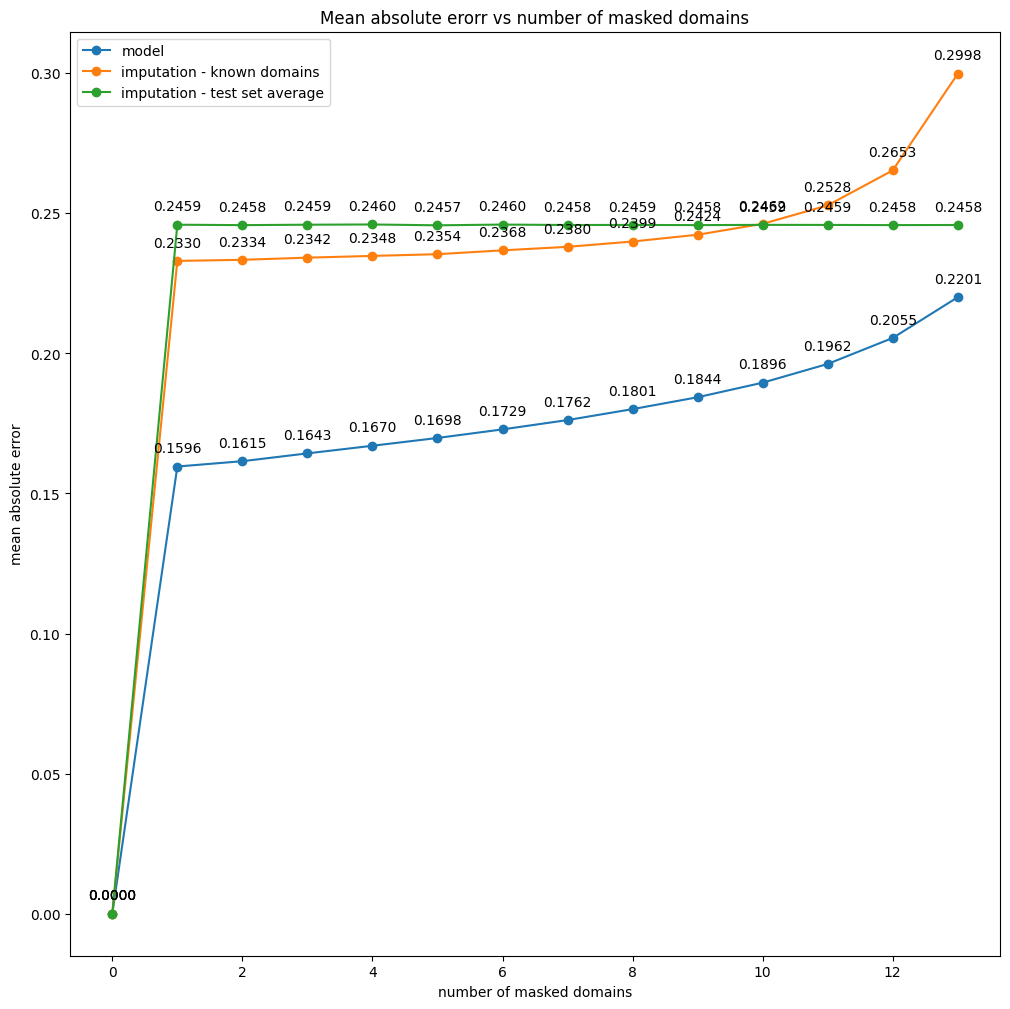

In [43]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_abs, yerr=error_prediction_abs, label="prediction", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_abs, yerr=error_imputation_abs, label="imputation")
x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_abs, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_abs, label="imputation - known domains", marker="o")
plt.plot(x_values, accuracy_list_dataimputation_abs, label="imputation - test set average", marker="o")

for x, y1, y2, y3 in zip(x_values, accuracy_list_prediction_abs, accuracy_list_knownimputation_abs, accuracy_list_dataimputation_abs):
    offset = 10

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y3)
    plt.annotate(label, # this is the text
                (x,y3), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center

plt.xlabel("number of masked domains")
plt.ylabel("mean absolute error")
plt.title("Mean absolute erorr vs number of masked domains")
plt.legend()

In [44]:
# torch.save(model.state_dict(), "model/base_quant01.pth")

In [45]:
test_data

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
2317999,0.628,1.00,0.933,0.500,0.480,0.632,0.470,0.667,0.690,0.800,1.00,0.393,0.564,1.000
4402179,0.926,1.00,1.000,1.000,1.000,0.320,0.633,0.894,0.707,1.000,1.00,1.000,0.838,0.680
4651174,0.337,1.00,0.815,0.963,0.845,0.733,1.000,1.000,1.000,1.000,1.00,1.000,0.838,0.326
2911601,0.615,0.39,0.933,0.414,0.260,0.431,0.310,1.000,0.310,0.621,1.00,0.350,0.430,0.874
3468637,0.071,0.09,0.733,0.186,0.030,0.053,0.460,0.317,0.000,0.071,0.20,0.172,0.273,0.893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607401,0.629,0.55,1.000,0.329,0.150,1.000,0.610,1.000,0.280,0.800,1.00,0.715,0.163,0.740
1215275,0.211,0.02,0.370,0.363,0.123,0.695,0.711,0.259,0.106,0.408,0.72,0.254,0.270,0.260
4989217,0.415,0.24,1.000,0.214,0.200,0.653,0.450,1.000,0.230,0.507,1.00,0.314,0.606,0.347
1884438,0.843,0.28,0.707,0.300,0.150,0.400,0.840,1.000,0.230,0.328,1.00,0.214,0.400,0.800


In [46]:
test_data.mean()

domain 1 score     0.537678
domain 2 score     0.532263
domain 3 score     0.839410
domain 4 score     0.504378
domain 5 score     0.291540
domain 6 score     0.432620
domain 7 score     0.515574
domain 8 score     0.603264
domain 9 score     0.395647
domain 10 score    0.556583
domain 11 score    0.794506
domain 12 score    0.432024
domain 13 score    0.683947
domain 14 score    0.622716
dtype: float64

In [47]:
torch.save(model, "model/clamp1.pt")

Bad pipe message: %s [b'\xf4`#\x8b\xeaE\xf7\xcaC\xbeFse\x95\x9e\x15M;\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11']
